In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import gym
from wutils import get_possible_actions

In [2]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, len_actions, vocab, hidden_size=16, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.hid_size = hidden_size
        self.emb_size = hidden_size // 2
        self.voc_len = len(vocab)

        self.critic_embedding = nn.Embedding(
            num_embeddings=self.voc_len,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.critic_lstm = nn.LSTM(self.emb_size, self.hid_size, batch_first=True)
        self.critic_linear1 = nn.Linear(self.hid_size, self.hid_size // 2)
        self.critic_linear2 = nn.Linear(self.hid_size // 2 + self.emb_size // 2, 1)

        self.actor_embedding = nn.Embedding(
            num_embeddings=self.voc_len,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.actor_lstm = nn.LSTM(self.emb_size, self.hid_size, batch_first=True)
        self.actor_linear1 = nn.Linear(self.hid_size, self.hid_size // 2)
        self.actor_linear2 = nn.Linear(self.hid_size // 2 + self.emb_size // 2, num_actions)
        
        self.action_embedding = nn.Embedding(
            num_embeddings=len_actions,
            embedding_dim=self.emb_size,
            padding_idx=0)
        self.action_linear = nn.Linear(self.emb_size, self.emb_size // 2)
        

    def forward(self, state, next_op_ind):
        self.hidden_actor = (torch.randn(1, 1, self.hid_size), torch.randn(1, 1, self.hid_size))
        self.hidden_critic = (torch.randn(1, 1, self.hid_size), torch.randn(1, 1, self.hid_size))

        print("part1")
        state = state[:,:min(state.shape[1], 3000)]
        print("Forward: state len {}".format(state.shape))
        
        print(next_op_ind)
        op_hid = F.relu(self.action_linear(self.action_embedding(next_op_ind))).view(1, self.emb_size // 2)
        
        value = self.critic_embedding(state)
        value, self.hidden_critic = self.critic_lstm(value, self.hidden_critic)
        value = value[:, -1, :]
        value = F.relu(self.critic_linear1(value))
        print(value.shape, op_hid.shape)
        value = self.critic_linear2(torch.cat((value, op_hid), dim=1))

        print("part2")
        policy_dist = self.actor_embedding(state)
        policy_dist, self.hidden_actor = self.actor_lstm(policy_dist, self.hidden_actor)
        policy_dist = policy_dist[:, -1, :]
        policy_dist = F.relu(self.actor_linear1(policy_dist))
        policy_dist = F.softmax(self.actor_linear2(torch.cat((policy_dist, op_hid), dim=1)), dim=1)

        return value, policy_dist

In [3]:
from wutils import ModelInfo
model_info = pickle.load(open("model1.mdlinfo", "rb"))
model = model_info.model
vocab = model_info.state_vocab
actions_vocab = model_info.actions_vocab
bpe_order = model_info.bpe_order
batch_size = 32


In [4]:
import logging
logging.getLogger().setLevel(logging.WARNING)

In [5]:
env = gym.make('wazuhl_gym:wazuhl-v0')
actions = get_possible_actions(env)

In [6]:
rl_model = pickle.load(open("a2c3.mdl", "rb"))
o2dict = pickle.load(open("o2dict", "rb"))

In [7]:
from state_action_models import O2ActionsModel, RandomActionsModel, O0ActionsModel, DropKeepActorCriticActionsModel, SupervisedActionsGenerator
from quality_eval import QualityEvaluator

In [60]:
#supervised_actions_model = SupervisedActionsGenerator(model, actions, vocab, actions_vocab, bpe_order, batch_size)
#random_model70 = RandomActionsModel(actions, seq_len=70)
random_model45 = RandomActionsModel(actions, seq_len=45)
#o0_model = O0ActionsModel()
#dropkeep_model = DropKeepActorCriticActionsModel(rl_model, o2dict)
#o2_model = O2ActionsModel()

qe = QualityEvaluator(env)
#qe.add_model(o0_model)
qe.add_model(random_model45)
#qe.add_model(random_model70)
#qe.add_model(dropkeep_model)
#qe.add_model(o2_model)
#qe.add_model(supervised_actions_model)

In [42]:
import logging
logging.getLogger().setLevel(logging.WARNING)

In [61]:
comparison_res = qe.compare_models(run_number=300)

targetlibinfo
targetlibinfo (0, 0) False
cross-dso-cfi (0, 0) False
slp-vectorizer (0, 0) False
strip-dead-prototypes (0, 0) False
licm (0, 0) False
callgraph (0, 0) False
deadargelim (0, 0) False
targetir (0, 0) False
gvn (0, 0) False
elim-avail-extern (0, 0) False
forceattrs (0, 0) False
assumptions (0, 0) False
memdep (0, 0) False
sroa (0, 0) False
targetlibinfo (0, 0) False
invalidate<all> (0, 0) False
jump-threading (0, 0) False
constmerge (0, 0) False
loop-instsimplify (0, 0) False
loop-deletion (0, 0) False
postdomtree (0, 0) False
adce (0, 0) False
argpromotion (0, 0) False
cfl-anders-aa (0, 0) False
early-cse (0, 0) False
name-anon-globals (0, 0) False
callgraph (0, 0) False
indvars (0, 0) False
correlated-propagation (0, 0) False
forceattrs (0, 0) False
targetir (0, 0) False
loop-deletion (0, 0) False
wholeprogramdevirt (0, 0) False
loops (0, 0) False
loop-simplify (0, 0) False
constmerge (0, 0) False
break-crit-edges (0, 0) False
constmerge (0, 0) False
licm (0, 0) False
mld

da (0, 0) False
jump-threading (0, 0) False
lower-expect (0, 0) False
aa (0, 0) False
function-attrs (0, 0) False
instcombine (0, 0) False
dce (0, 0) False
mem2reg (0, 0) False
jump-threading (0, 0) False
inferattrs (0, 0) False
loop-sink (0, 0) False
dce (0, 0) False
loop-idiom (0, 0) False
strength-reduce (0, 0) False
basic-aa (0, 0) False
da (0, 0) False
correlated-propagation (0, 0) False
ipsccp (0, 0) False
lazy-value-info (0, 0) False
strip-dead-prototypes (0, 0) False
targetir (0, 0) False
module-summary (0, 0) False
partial-inliner (0, 0) False
elim-avail-extern (0, 0) False
strength-reduce (0, 0) False
constmerge (0, 0) False
slp-vectorizer (0, 0) False
ipsccp (0, 0) False
globalsplit (0, 0) False
forceattrs (0, 0) False
early-cse (0, 0) False
targetlibinfo (0, 0) False
unroll-full (0, 0) False
lower-expect (0, 0) False
basic-aa (0, 0) False
dse
dse (0, 0) False
licm (0, 0) False
correlated-propagation (0, 0) False
indvars (0, 0) False
lower-guard-intrinsic (0, 0) False
block-

aa-eval (0, 0) False
tailcallelim (0, 0) False
sroa (0, 0) False
break-crit-edges (0, 0) False
partial-inliner (0, 0) False
globalsplit (0, 0) False
name-anon-globals (0, 0) False
loop-instsimplify (0, 0) False
ipsccp (0, 0) False
lcg (0, 0) False
regions (0, 0) False
loop-distribute (0, 0) False
deadargelim (0, 0) False
tailcallelim (0, 0) False
block-freq (0, 0) False
unroll (0, 0) False
simplify-cfg (0, 0) False
correlated-propagation (0, 0) False
loop-deletion (0, 0) False
invalidate<all> (0, 0) False
dse (0, 0) False
rotate (0, 0) False
loop-load-elim (0, 0) False
always-inline (0, 0) False
speculative-execution (0, 0) False
loop-sink (0, 0) False
inferattrs (0, 0) False
tailcallelim (0, 0) False
break-crit-edges (0, 0) False
add-discriminators
add-discriminators (0, 0) False
lower-expect (0, 0) False
demanded-bits (0, 0) False
globalsplit (0, 0) False
module-summary (0, 0) False
loop-distribute (0, 0) False
simplify-cfg (0, 0) False
globalopt (0, 0) False
lower-guard-intrinsic (0

strip-dead-prototypes (0, 0) False
dse (0, 0) False
globals-aa (0, 0) False
elim-avail-extern (0, 0) False
domfrontier (0, 0) False
adce (0, 0) False
globalsplit (0, 0) False
sroa (0, 0) False
demanded-bits (0, 0) False
break-crit-edges (0, 0) False
loop-distribute (0, 0) False
dce (0, 0) False
wholeprogramdevirt (0, 0) False
elim-avail-extern (0, 0) False
inferattrs (0, 0) False
lowertypetests (0, 0) False
aa-eval (0, 0) False
loop-predication
loop-predication (0, 0) False
always-inline (0, 0) False
correlated-propagation (0, 0) False
dse (0, 0) False
sroa (0, 0) False
sroa (0, 0) False
partially-inline-libcalls (0, 0) False
cross-dso-cfi (0, 0) False
lowerinvoke (0, 0) False
elim-avail-extern (0, 0) False
instcombine (0, 0) False
slp-vectorizer (0, 0) False
scalar-evolution (0, 0) False
rotate (0, 0) False
aa (0, 0) False
loop-vectorize (0, 0) False
constmerge (0, 0) False
bdce (0, 0) False
sink (0, 0) False
indvars (0, 0) False
elim-avail-extern (0, 0) False
invalidate<all> (0, 0) F

globalopt
globalopt (0, 0) False
wholeprogramdevirt (0, 0) False
name-anon-globals (0, 0) False
loop-vectorize (0, 0) False
speculative-execution (0, 0) False
inferattrs (0, 0) False
reassociate (0, 0) False
aa-eval (0, 0) False
adce (0, 0) False
memoryssa (0, 0) False
adce (0, 0) False
function-attrs (0, 0) False
guard-widening (0, 0) False
tailcallelim (0, 0) False
assumptions (0, 0) False
break-crit-edges (0, 0) False
targetir (0, 0) False
postdomtree (0, 0) False
mem2reg (0, 0) False
regions (0, 0) False
gvn (0, 0) False
deadargelim (0, 0) False
wholeprogramdevirt (0, 0) False
regions (0, 0) False
lower-expect (0, 0) False
simplify-cfg (0, 0) False
gvn (0, 0) False
loop-predication (0, 0) False
name-anon-globals (0, 0) False
partially-inline-libcalls (0, 0) False
domfrontier (0, 0) False
basic-aa (0, 0) False
gvn-hoist (0, 0) False
guard-widening (0, 0) False
bdce (0, 0) False
mem2reg (0, 0) False
lowerinvoke (0, 0) False
domtree (0, 0) False
targetir (0, 0) False
ipsccp (0, 0) Fal

ipsccp (0, 0) False
loop-distribute (0, 0) False
memoryssa (0, 0) False
instsimplify (0, 0) False
dce (0, 0) False
loop-distribute (0, 0) False
type-based-aa (0, 0) False
bdce (0, 0) False
domtree (0, 0) False
add-discriminators (0, 0) False
memoryssa (0, 0) False
postdomtree (0, 0) False
loop-distribute (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
lowertypetests (0, 0) False
mldst-motion (0, 0) False
alignment-from-assumptions (0, 0) False
sink (0, 0) False
demanded-bits (0, 0) False
sccp (0, 0) False
loop-load-elim (0, 0) False
demanded-bits (0, 0) False
scoped-noalias-aa (0, 0) False
lower-guard-intrinsic (0, 0) False
loop-load-elim (0, 0) False
reassociate
reassociate (0, 0) False
partially-inline-libcalls (0, 0) False
adce (0, 0) False
name-anon-globals (0, 0) False
inline (0, 0) False
gvn (0, 0) False
correlated-propagation (0, 0) False
constmerge (0, 0) False
module-summary (0, 0) False
wholeprogramdevirt (0, 0) False
speculative-execution (0, 0) False
postdomtree (0, 0

cfl-steens-aa (0, 0) False
elim-avail-extern (0, 0) False
gvn-hoist (0, 0) False
instsimplify (0, 0) False
partial-inliner (0, 0) False
instsimplify (0, 0) False
domtree (0, 0) False
wholeprogramdevirt (0, 0) False
ipsccp (0, 0) False
loop-load-elim (0, 0) False
invalidate<all> (0, 0) False
globalopt (0, 0) False
tailcallelim (0, 0) False
constmerge (0, 0) False
speculative-execution (0, 0) False
deadargelim
deadargelim (0, 0) False
rewrite-symbols (0, 0) False
guard-widening (0, 0) False
block-freq (0, 0) False
name-anon-globals (0, 0) False
loop-idiom (0, 0) False
lowertypetests (0, 0) False
cross-dso-cfi (0, 0) False
loop-sink (0, 0) False
lower-expect (0, 0) False
dce (0, 0) False
globaldce (0, 0) False
callgraph (0, 0) False
rotate (0, 0) False
rotate (0, 0) False
loop-vectorize (0, 0) False
inline (0, 0) False
block-freq (0, 0) False
unroll (0, 0) False
postdomtree (0, 0) False
globalsplit (0, 0) False
module-summary (0, 0) False
instcombine (0, 0) False
lower-guard-intrinsic (0,

mldst-motion (0, 0) False
name-anon-globals (0, 0) False
adce (0, 0) False
targetir (0, 0) False
speculative-execution (0, 0) False
loop-simplify (0, 0) False
globals-aa
globals-aa (0, 0) False
loop-instsimplify (0, 0) False
loop-sink (0, 0) False
jump-threading (0, 0) False
invalidate<all> (0, 0) False
lowertypetests (0, 0) False
indvars (0, 0) False
type-based-aa (0, 0) False
instsimplify (0, 0) False
scoped-noalias-aa (0, 0) False
memdep (0, 0) False
speculative-execution (0, 0) False
function-attrs (0, 0) False
regions (0, 0) False
assumptions (0, 0) False
globalopt (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
slp-vectorizer (0, 0) False
da (0, 0) False
scoped-noalias-aa (0, 0) False
mem2reg (0, 0) False
slp-vectorizer (0, 0) False
speculative-execution (0, 0) False
rewrite-symbols (0, 0) False
break-crit-edges (0, 0) False
loop-distribute (0, 0) False
always-inline (0, 0) False
inferattrs (0, 0) False
demanded-bits (0, 0) False
lowertypetests (0, 0) False
basic-aa (0, 0) 

constmerge
constmerge (0, 0) False
name-anon-globals (0, 0) False
mldst-motion (0, 0) False
instsimplify (0, 0) False
argpromotion (0, 0) False
deadargelim (0, 0) False
unroll (0, 0) False
loop-simplify (0, 0) False
targetir (0, 0) False
float2int (0, 0) False
lowerinvoke (0, 0) False
strip-dead-prototypes (0, 0) False
always-inline (0, 0) False
lcssa (0, 0) False
reassociate (0, 0) False
speculative-execution (0, 0) False
targetir (0, 0) False
sink (0, 0) False
instsimplify (0, 0) False
bdce (0, 0) False
targetir (0, 0) False
invalidate<all> (0, 0) False
da (0, 0) False
aa-eval (0, 0) False
strength-reduce (0, 0) False
indvars (0, 0) False
break-crit-edges (0, 0) False
scev-aa (0, 0) False
domtree (0, 0) False
dse (0, 0) False
cross-dso-cfi (0, 0) False
scoped-noalias-aa (0, 0) False
lazy-value-info (0, 0) False
partially-inline-libcalls (0, 0) False
memcpyopt (0, 0) False
inferattrs (0, 0) False
cfl-anders-aa (0, 0) False
targetlibinfo (0, 0) False
alignment-from-assumptions (0, 0) F

lcssa (0, 0) False
deadargelim (0, 0) False
loop-sink (0, 0) False
lowertypetests (0, 0) False
always-inline (0, 0) False
cfl-anders-aa (0, 0) False
regions (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
alignment-from-assumptions (0, 0) False
scev-aa (0, 0) False
argpromotion (0, 0) False
function-attrs (0, 0) False
cfl-steens-aa (0, 0) False
branch-prob (0, 0) False
libcalls-shrinkwrap (0, 0) False
assumptions (0, 0) False
argpromotion (0, 0) False
loop-vectorize (0, 0) False
targetlibinfo (0, 0) False
dce (0, 0) False
block-freq (0, 0) False
simplify-cfg (0, 0) False
elim-avail-extern (0, 0) False
lowertypetests (0, 0) False
early-cse (0, 0) False
loop-vectorize (0, 0) False
loop-sink (0, 0) False
scalar-evolution
scalar-evolution (0, 0) False
argpromotion (0, 0) False
lazy-value-info (0, 0) False
lazy-value-info (0, 0) False
reassociate (0, 0) False
indvars (0, 0) False
speculative-execution (0, 0) False
da (0, 0) False
always-inline (0, 0) False
loop-predication (0, 0) Fals

loop-distribute (0, 0) False
cross-dso-cfi (0, 0) False
memoryssa (0, 0) False
invalidate<all> (0, 0) False
assumptions (0, 0) False
globaldce (0, 0) False
adce (0, 0) False
rewrite-symbols (0, 0) False
loop-distribute (0, 0) False
callgraph (0, 0) False
adce (0, 0) False
globalsplit (0, 0) False
gvn-hoist (0, 0) False
loop-data-prefetch (0, 0) False
lowerinvoke (0, 0) False
invalidate<all>
invalidate<all> (0, 0) False
lower-guard-intrinsic (0, 0) False
argpromotion (0, 0) False
unroll-full (0, 0) False
forceattrs (0, 0) False
alignment-from-assumptions (0, 0) False
constmerge (0, 0) False
loop-distribute (0, 0) False
dse (0, 0) False
function-attrs (0, 0) False
inferattrs (0, 0) False
memcpyopt (0, 0) False
instcombine (0, 0) False
loops (0, 0) False
lcssa (0, 0) False
licm (0, 0) False
loop-predication (0, 0) False
sink (0, 0) False
opt-remark-emit (0, 0) False
invalidate<all> (0, 0) False
constmerge (0, 0) False
gvn-hoist (0, 0) False
loop-predication (0, 0) False
add-discriminators

float2int (0, 0) False
float2int (0, 0) False
loop-simplify (0, 0) False
elim-avail-extern (0, 0) False
inline (0, 0) False
loop-distribute
loop-distribute (0, 0) False
memdep (0, 0) False
aa (0, 0) False
domtree (0, 0) False
inline (0, 0) False
guard-widening (0, 0) False
always-inline (0, 0) False
gvn (0, 0) False
targetir (0, 0) False
licm (0, 0) False
rotate (0, 0) False
loop-data-prefetch (0, 0) False
function-attrs (0, 0) False
break-crit-edges (0, 0) False
function-attrs (0, 0) False
loop-vectorize (0, 0) False
break-crit-edges (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
loop-idiom (0, 0) False
forceattrs (0, 0) False
demanded-bits (0, 0) False
float2int (0, 0) False
loop-load-elim (0, 0) False
module-summary (0, 0) False
lcssa (0, 0) False
mldst-motion (0, 0) False
globaldce (0, 0) False
domtree (0, 0) False
rpo-functionattrs (0, 0) False
instcombine (0, 0) False
argpromotion (0, 0) False
libcalls-shrinkwrap (0, 0) False
loop-simplify (0, 0) False
scalar-evolution (0,

lcssa (0, 0) False
domfrontier (0, 0) False
targetlibinfo (0, 0) False
inline (0, 0) False
name-anon-globals (0, 0) False
reassociate (0, 0) False
elim-avail-extern (0, 0) False
wholeprogramdevirt (0, 0) False
instsimplify (0, 0) False
always-inline (0, 0) False
targetlibinfo (0, 0) False
globalopt (0, 0) False
constmerge (0, 0) False
type-based-aa (0, 0) False
name-anon-globals (0, 0) False
aa (0, 0) False
targetir (0, 0) False
early-cse (0, 0) False
memoryssa (0, 0) False
function-attrs (0, 0) False
unroll-full (0, 0) False
unroll-full (0, 0) False
gvn (0, 0) False
memoryssa (0, 0) False
bdce (0, 0) False
sroa (0, 0) False
sccp (0, 0) False
break-crit-edges (0, 0) False
type-based-aa (0, 0) False
callgraph (0, 0) False
alignment-from-assumptions (0, 0) False
da (0, 0) False
sroa (0, 0) False
invalidate<all> (0, 0) False
aa (0, 0) False
memoryssa (0, 0) False
elim-avail-extern
elim-avail-extern (0, 0) False
adce (0, 0) False
lowerinvoke (0, 0) False
rotate (0, 0) False
opt-remark-emit

lcssa (0, 0) False
lazy-value-info (0, 0) False
scev-aa (0, 0) False
loops (0, 0) False
elim-avail-extern (0, 0) False
sccp (0, 0) False
domfrontier (0, 0) False
strength-reduce (0, 0) False
gvn-hoist (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
partial-inliner (0, 0) False
scoped-noalias-aa (0, 0) False
sroa (0, 0) False
guard-widening (0, 0) False
alignment-from-assumptions (0, 0) False
reassociate (0, 0) False
loop-sink (0, 0) False
ipsccp (0, 0) False
lowertypetests
lowertypetests (0, 0) False
slp-vectorizer (0, 0) False
tailcallelim (0, 0) False
basic-aa (0, 0) False
targetlibinfo (0, 0) False
targetlibinfo (0, 0) False
name-anon-globals (0, 0) False
libcalls-shrinkwrap (0, 0) False
sink (0, 0) False
indvars (0, 0) False
sroa (0, 0) False
type-based-aa (0, 0) False
module-summary (0, 0) False
cfl-anders-aa (0, 0) False
loops (0, 0) False
forceattrs (0, 0) False
cfl-anders-aa (0, 0) False
loop-deletion (0, 0) False
scoped-noalias-aa (0, 0) False
inline (0, 0) False
dce (0,

loop-deletion (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
argpromotion (0, 0) False
simplify-cfg (0, 0) False
strip-dead-prototypes (0, 0) False
loop-simplify (0, 0) False
aa-eval (0, 0) False
aa (0, 0) False
aa (0, 0) False
aa-eval
aa-eval (0, 0) False
aa (0, 0) False
loop-sink (0, 0) False
globals-aa (0, 0) False
loop-data-prefetch (0, 0) False
loop-load-elim (0, 0) False
loop-instsimplify (0, 0) False
name-anon-globals (0, 0) False
loop-load-elim (0, 0) False
libcalls-shrinkwrap (0, 0) False
constmerge (0, 0) False
loop-idiom (0, 0) False
gvn-hoist (0, 0) False
loop-deletion (0, 0) False
lowertypetests (0, 0) False
rewrite-symbols (0, 0) False
adce (0, 0) False
scalar-evolution (0, 0) False
indvars (0, 0) False
dse (0, 0) False
module-summary (0, 0) False
loop-instsimplify (0, 0) False
loop-distribute (0, 0) False
indvars (0, 0) False
rewrite-symbols (0, 0) False
loop-vectorize (0, 0) False
aa-eval (0, 0) False
loop-sink (0, 0) False
memcpyopt (0, 0) False
scoped-noalias-a

mem2reg (0, 0) False
scoped-noalias-aa
scoped-noalias-aa (0, 0) False
guard-widening (0, 0) False
memcpyopt (0, 0) False
opt-remark-emit (0, 0) False
da (0, 0) False
targetir (0, 0) False
wholeprogramdevirt (0, 0) False
early-cse (0, 0) False
callgraph (0, 0) False
branch-prob (0, 0) False
reassociate (0, 0) False
branch-prob (0, 0) False
targetir (0, 0) False
deadargelim (0, 0) False
mldst-motion (0, 0) False
lcg (0, 0) False
deadargelim (0, 0) False
postdomtree (0, 0) False
wholeprogramdevirt (0, 0) False
inferattrs (0, 0) False
adce (0, 0) False
scoped-noalias-aa (0, 0) False
loop-instsimplify (0, 0) False
speculative-execution (0, 0) False
dse (0, 0) False
forceattrs (0, 0) False
loop-sink (0, 0) False
callgraph (0, 0) False
simplify-cfg (0, 0) False
speculative-execution (0, 0) False
mem2reg (0, 0) False
globals-aa (0, 0) False
targetir (0, 0) False
slp-vectorizer (0, 0) False
loop-simplify (0, 0) False
speculative-execution (0, 0) False
always-inline (0, 0) False
memdep (0, 0) Fa

always-inline (0, 0) False
function-attrs (0, 0) False
rpo-functionattrs (0, 0) False
tailcallelim (0, 0) False
indvars (0, 0) False
postdomtree (0, 0) False
elim-avail-extern (0, 0) False
lcssa (0, 0) False
loop-predication (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
float2int (0, 0) False
partial-inliner (0, 0) False
globalsplit (0, 0) False
mem2reg (0, 0) False
inferattrs (0, 0) False
globalsplit (0, 0) False
lower-guard-intrinsic (0, 0) False
partial-inliner (0, 0) False
loop-instsimplify (0, 0) False
gvn-hoist (0, 0) False
cfl-anders-aa (0, 0) False
early-cse (0, 0) False
guard-widening (0, 0) False
gvn-hoist (0, 0) False
loop-instsimplify (0, 0) False
cross-dso-cfi (0, 0) False
rpo-functionattrs (0, 0) False
globaldce (0, 0) False
invalidate<all> (0, 0) False
dse (0, 0) False
lowertypetests (0, 0) False
dce (0, 0) False
forceattrs (0, 0) False
lcg (0, 0) False
loop-sink (0, 0) False
float2int (0, 0) False
rotate
rotate (0, 0) False
lowertypetests (0, 0) False
demanded-b

add-discriminators (0, 0) False
indvars (0, 0) False
loop-vectorize (0, 0) False
scev-aa (0, 0) False
scalar-evolution (0, 0) False
globaldce (0, 0) False
guard-widening (0, 0) False
loop-deletion (0, 0) False
loop-distribute (0, 0) False
add-discriminators (0, 0) False
sink (0, 0) False
branch-prob (0, 0) False
targetlibinfo (0, 0) False
assumptions (0, 0) False
domtree (0, 0) False
cross-dso-cfi (0, 0) False
domfrontier (0, 0) False
rewrite-symbols (0, 0) False
opt-remark-emit (0, 0) False
sroa (0, 0) False
block-freq (0, 0) False
sccp (0, 0) False
demanded-bits (0, 0) False
adce (0, 0) False
lower-guard-intrinsic (0, 0) False
globaldce (0, 0) False
memcpyopt (0, 0) False
branch-prob
branch-prob (0, 0) False
inline (0, 0) False
scoped-noalias-aa (0, 0) False
strength-reduce (0, 0) False
gvn-hoist (0, 0) False
dse (0, 0) False
globalopt (0, 0) False
cross-dso-cfi (0, 0) False
forceattrs (0, 0) False
globalsplit (0, 0) False
unroll-full (0, 0) False
name-anon-globals (0, 0) False
corre

bdce (0, 0) False
unroll-full (0, 0) False
targetlibinfo (0, 0) False
loop-deletion (0, 0) False
opt-remark-emit (0, 0) False
inline (0, 0) False
loop-data-prefetch (0, 0) False
lowertypetests (0, 0) False
loop-simplify (0, 0) False
gvn (0, 0) False
gvn-hoist (0, 0) False
domfrontier (0, 0) False
aa (0, 0) False
globalopt (0, 0) False
always-inline (0, 0) False
callgraph (0, 0) False
aa-eval (0, 0) False
strength-reduce (0, 0) False
forceattrs
forceattrs (0, 0) False
invalidate<all> (0, 0) False
aa (0, 0) False
lazy-value-info (0, 0) False
loop-predication (0, 0) False
unroll-full (0, 0) False
basic-aa (0, 0) False
targetlibinfo (0, 0) False
globalopt (0, 0) False
loop-sink (0, 0) False
memdep (0, 0) False
da (0, 0) False
guard-widening (0, 0) False
name-anon-globals (0, 0) False
slp-vectorizer (0, 0) False
inferattrs (0, 0) False
loop-predication (0, 0) False
elim-avail-extern (0, 0) False
float2int (0, 0) False
ipsccp (0, 0) False
constmerge (0, 0) False
memoryssa (0, 0) False
basic-

correlated-propagation (0, 0) False
wholeprogramdevirt (0, 0) False
loop-distribute (0, 0) False
inferattrs (0, 0) False
invalidate<all> (0, 0) False
targetir (0, 0) False
instcombine (0, 0) False
loop-distribute (0, 0) False
simplify-cfg (0, 0) False
loops (0, 0) False
simplify-cfg (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
aa (0, 0) False
jump-threading (0, 0) False
branch-prob (0, 0) False
lower-expect (0, 0) False
elim-avail-extern (0, 0) False
lower-expect (0, 0) False
invalidate<all> (0, 0) False
sroa (0, 0) False
gvn-hoist (0, 0) False
memoryssa (0, 0) False
wholeprogramdevirt (0, 0) False
opt-remark-emit (0, 0) False
inline (0, 0) False
callgraph (0, 0) False
wholeprogramdevirt (0, 0) False
scoped-noalias-aa (0, 0) False
loop-simplify (0, 0) False
loop-instsimplify (0, 0) False
loop-predication (0, 0) False
licm (0, 0) False
mldst-motion (0, 0) False
lcssa (0, 0) False
lower-expect (0, 0) False
loop-simplify (0, 0) False
gvn
gvn (0, 0) False
scoped-noalias-aa (0, 0) 

elim-avail-extern (0, 0) False
mem2reg (0, 0) False
loop-data-prefetch (0, 0) False
gvn-hoist (0, 0) False
domtree (0, 0) False
licm (0, 0) False
callgraph (0, 0) False
memdep (0, 0) False
memdep (0, 0) False
aa (0, 0) False
postdomtree (0, 0) False
mldst-motion (0, 0) False
correlated-propagation (0, 0) False
regions (0, 0) False
tailcallelim (0, 0) False
licm (0, 0) False
loop-predication (0, 0) False
scalar-evolution (0, 0) False
instcombine (0, 0) False
globalsplit (0, 0) False
float2int (0, 0) False
cfl-steens-aa (0, 0) False
loop-deletion (0, 0) False
elim-avail-extern (0, 0) False
globaldce (0, 0) False
unroll-full (0, 0) False
sroa (0, 0) False
loop-distribute
loop-distribute (0, 0) False
dce (0, 0) False
loop-data-prefetch (0, 0) False
inline (0, 0) False
lcg (0, 0) False
deadargelim (0, 0) False
cross-dso-cfi (0, 0) False
tailcallelim (0, 0) False
loop-simplify (0, 0) False
dce (0, 0) False
basic-aa (0, 0) False
instcombine (0, 0) False
loop-load-elim (0, 0) False
float2int (

loop-sink (0, 0) False
partially-inline-libcalls (0, 0) False
alignment-from-assumptions (0, 0) False
loop-distribute (0, 0) False
adce (0, 0) False
lowertypetests (0, 0) False
lower-expect (0, 0) False
gvn-hoist (0, 0) False
loop-data-prefetch (0, 0) False
rewrite-symbols
rewrite-symbols (0, 0) False
forceattrs (0, 0) False
memoryssa (0, 0) False
lcssa (0, 0) False
alignment-from-assumptions (0, 0) False
strip-dead-prototypes (0, 0) False
mldst-motion (0, 0) False
loop-distribute (0, 0) False
callgraph (0, 0) False
postdomtree (0, 0) False
domfrontier (0, 0) False
domfrontier (0, 0) False
memdep (0, 0) False
inferattrs (0, 0) False
loop-instsimplify (0, 0) False
name-anon-globals (0, 0) False
demanded-bits (0, 0) False
lowerinvoke (0, 0) False
sroa (0, 0) False
globals-aa (0, 0) False
block-freq (0, 0) False
domfrontier (0, 0) False
mem2reg (0, 0) False
lowertypetests (0, 0) False
slp-vectorizer (0, 0) False
sccp (0, 0) False
loop-vectorize (0, 0) False
mem2reg (0, 0) False
opt-remark

targetir
targetir (0, 0) False
rewrite-symbols (0, 0) False
loop-instsimplify (0, 0) False
regions (0, 0) False
loop-load-elim (0, 0) False
strip-dead-prototypes (0, 0) False
add-discriminators (0, 0) False
scoped-noalias-aa (0, 0) False
sroa (0, 0) False
function-attrs (0, 0) False
targetir (0, 0) False
targetlibinfo (0, 0) False
domfrontier (0, 0) False
sccp (0, 0) False
opt-remark-emit (0, 0) False
globalsplit (0, 0) False
unroll (0, 0) False
unroll (0, 0) False
indvars (0, 0) False
loop-load-elim (0, 0) False
lowertypetests (0, 0) False
sink (0, 0) False
aa-eval (0, 0) False
alignment-from-assumptions (0, 0) False
loop-deletion (0, 0) False
rpo-functionattrs (0, 0) False
lcssa (0, 0) False
argpromotion (0, 0) False
cfl-anders-aa (0, 0) False
demanded-bits (0, 0) False
type-based-aa (0, 0) False
scoped-noalias-aa (0, 0) False
add-discriminators (0, 0) False
adce (0, 0) False
sink (0, 0) False
reassociate (0, 0) False
always-inline (0, 0) False
unroll (0, 0) False
licm (0, 0) False
p

lowertypetests (0, 0) False
globaldce (0, 0) False
unroll (0, 0) False
jump-threading (0, 0) False
dse (0, 0) False
float2int (0, 0) False
add-discriminators (0, 0) False
libcalls-shrinkwrap (0, 0) False
domfrontier (0, 0) False
globaldce (0, 0) False
callgraph (0, 0) False
cfl-anders-aa (0, 0) False
name-anon-globals (0, 0) False
rpo-functionattrs (0, 0) False
lowerinvoke (0, 0) False
alignment-from-assumptions (0, 0) False
postdomtree (0, 0) False
inferattrs (0, 0) False
lower-expect (0, 0) False
sink (0, 0) False
assumptions (0, 0) False
jump-threading (0, 0) False
cfl-steens-aa (0, 0) False
callgraph (0, 0) False
loops (0, 0) False
scev-aa (0, 0) False
unroll (0, 0) False
strength-reduce
strength-reduce (0, 0) False
partially-inline-libcalls (0, 0) False
licm (0, 0) False
globaldce (0, 0) False
memoryssa (0, 0) False
speculative-execution (0, 0) False
block-freq (0, 0) False
globals-aa (0, 0) False
always-inline (0, 0) False
memdep (0, 0) False
rpo-functionattrs (0, 0) False
da (0,

aa (0, 0) False
type-based-aa (0, 0) False
globals-aa (0, 0) False
module-summary (0, 0) False
scoped-noalias-aa (0, 0) False
mldst-motion (0, 0) False
reassociate (0, 0) False
demanded-bits (0, 0) False
speculative-execution (0, 0) False
inferattrs
inferattrs (0, 0) False
lcg (0, 0) False
gvn (0, 0) False
jump-threading (0, 0) False
partially-inline-libcalls (0, 0) False
domtree (0, 0) False
loop-data-prefetch (0, 0) False
basic-aa (0, 0) False
reassociate (0, 0) False
partially-inline-libcalls (0, 0) False
ipsccp (0, 0) False
loop-instsimplify (0, 0) False
block-freq (0, 0) False
deadargelim (0, 0) False
sink (0, 0) False
name-anon-globals (0, 0) False
module-summary (0, 0) False
loop-load-elim (0, 0) False
basic-aa (0, 0) False
indvars (0, 0) False
lazy-value-info (0, 0) False
add-discriminators (0, 0) False
loop-vectorize (0, 0) False
domfrontier (0, 0) False
loop-instsimplify (0, 0) False
loops (0, 0) False
loop-vectorize (0, 0) False
lowerinvoke (0, 0) False
break-crit-edges (0, 

strip-dead-prototypes
strip-dead-prototypes (0, 0) False
rotate (0, 0) False
targetir (0, 0) False
postdomtree (0, 0) False
mldst-motion (0, 0) False
add-discriminators (0, 0) False
rotate (0, 0) False
bdce (0, 0) False
always-inline (0, 0) False
cfl-anders-aa (0, 0) False
alignment-from-assumptions (0, 0) False
branch-prob (0, 0) False
assumptions (0, 0) False
wholeprogramdevirt (0, 0) False
loop-instsimplify (0, 0) False
scev-aa (0, 0) False
loop-simplify (0, 0) False
rotate (0, 0) False
targetlibinfo (0, 0) False
cfl-steens-aa (0, 0) False
function-attrs (0, 0) False
demanded-bits (0, 0) False
loop-predication (0, 0) False
opt-remark-emit (0, 0) False
cfl-steens-aa (0, 0) False
speculative-execution (0, 0) False
regions (0, 0) False
callgraph (0, 0) False
argpromotion (0, 0) False
deadargelim (0, 0) False
lowerinvoke (0, 0) False
cross-dso-cfi (0, 0) False
invalidate<all> (0, 0) False
cfl-anders-aa (0, 0) False
loop-idiom (0, 0) False
aa-eval (0, 0) False
float2int (0, 0) False
loop

demanded-bits (0, 0) False
mem2reg (0, 0) False
correlated-propagation (0, 0) False
unroll-full (0, 0) False
break-crit-edges (0, 0) False
indvars (0, 0) False
assumptions (0, 0) False
partially-inline-libcalls (0, 0) False
break-crit-edges (0, 0) False
demanded-bits (0, 0) False
bdce (0, 0) False
sccp (0, 0) False
rewrite-symbols (0, 0) False
scev-aa (0, 0) False
lazy-value-info (0, 0) False
add-discriminators (0, 0) False
postdomtree (0, 0) False
lowertypetests (0, 0) False
alignment-from-assumptions (0, 0) False
partial-inliner (0, 0) False
aa (0, 0) False
sccp (0, 0) False
callgraph (0, 0) False
indvars (0, 0) False
targetir (0, 0) False
targetlibinfo (0, 0) False
globals-aa (0, 0) False
loop-load-elim (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
scev-aa
scev-aa (0, 0) False
loop-vectorize (0, 0) False
inferattrs (0, 0) False
sccp (0, 0) False
slp-vectorizer (0, 0) False
instcombine (0, 0) False
loops (0, 0) False
partially-inline-libcalls (0, 0) False
domtree (0, 0) False

globaldce (0, 0) False
domfrontier (0, 0) False
bdce (0, 0) False
cfl-steens-aa (0, 0) False
regions (0, 0) False
da (0, 0) False
partially-inline-libcalls (0, 0) False
early-cse (0, 0) False
name-anon-globals (0, 0) False
ipsccp (0, 0) False
instsimplify (0, 0) False
lcg (0, 0) False
instcombine (0, 0) False
globalsplit (0, 0) False
licm (0, 0) False
scalar-evolution (0, 0) False
loop-vectorize (0, 0) False
guard-widening (0, 0) False
assumptions (0, 0) False
alignment-from-assumptions
alignment-from-assumptions (0, 0) False
loop-sink (0, 0) False
loop-predication (0, 0) False
aa-eval (0, 0) False
function-attrs (0, 0) False
loop-data-prefetch (0, 0) False
instsimplify (0, 0) False
sink (0, 0) False
forceattrs (0, 0) False
slp-vectorizer (0, 0) False
jump-threading (0, 0) False
type-based-aa (0, 0) False
deadargelim (0, 0) False
name-anon-globals (0, 0) False
float2int (0, 0) False
dse (0, 0) False
jump-threading (0, 0) False
forceattrs (0, 0) False
basic-aa (0, 0) False
scev-aa (0, 0

invalidate<all> (0, 0) False
loops
loops (0, 0) False
inferattrs (0, 0) False
demanded-bits (0, 0) False
unroll (0, 0) False
function-attrs (0, 0) False
argpromotion (0, 0) False
dse (0, 0) False
type-based-aa (0, 0) False
basic-aa (0, 0) False
lower-guard-intrinsic (0, 0) False
rpo-functionattrs (0, 0) False
strength-reduce (0, 0) False
branch-prob (0, 0) False
globaldce (0, 0) False
tailcallelim (0, 0) False
loop-predication (0, 0) False
deadargelim (0, 0) False
demanded-bits (0, 0) False
dse (0, 0) False
basic-aa (0, 0) False
adce (0, 0) False
dce (0, 0) False
tailcallelim (0, 0) False
instcombine (0, 0) False
ipsccp (0, 0) False
ipsccp (0, 0) False
cfl-steens-aa (0, 0) False
rewrite-symbols (0, 0) False
lazy-value-info (0, 0) False
aa-eval (0, 0) False
libcalls-shrinkwrap (0, 0) False
dce (0, 0) False
cfl-steens-aa (0, 0) False
globals-aa (0, 0) False
block-freq (0, 0) False
basic-aa (0, 0) False
adce (0, 0) False
deadargelim (0, 0) False
slp-vectorizer (0, 0) False
demanded-bits (

postdomtree (0, 0) False
aa (0, 0) False
gvn (0, 0) False
loop-deletion (0, 0) False
jump-threading (0, 0) False
float2int (0, 0) False
function-attrs (0, 0) False
globals-aa (0, 0) False
loop-vectorize (0, 0) False
unroll-full (0, 0) False
assumptions (0, 0) False
opt-remark-emit (0, 0) False
forceattrs (0, 0) False
adce (0, 0) False
domfrontier (0, 0) False
module-summary (0, 0) False
loop-predication (0, 0) False
float2int (0, 0) False
loop-data-prefetch (0, 0) False
loop-predication (0, 0) False
break-crit-edges (0, 0) False
unroll (0, 0) False
adce (0, 0) False
loop-instsimplify (0, 0) False
instsimplify (0, 0) False
dce (0, 0) False
strength-reduce (0, 0) False
da (0, 0) False
gvn (0, 0) False
lower-guard-intrinsic
lower-guard-intrinsic (0, 0) False
inline (0, 0) False
alignment-from-assumptions (0, 0) False
sink (0, 0) False
constmerge (0, 0) False
loop-idiom (0, 0) False
inferattrs (0, 0) False
partial-inliner (0, 0) False
early-cse (0, 0) False
sccp (0, 0) False
branch-prob (0

module-summary (0, 0) False
aa-eval (0, 0) False
cfl-anders-aa (0, 0) False
wholeprogramdevirt (0, 0) False
strength-reduce (0, 0) False
simplify-cfg (0, 0) False
domfrontier (0, 0) False
regions (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
gvn (0, 0) False
elim-avail-extern (0, 0) False
loop-instsimplify (0, 0) False
guard-widening (0, 0) False
da (0, 0) False
targetir (0, 0) False
deadargelim (0, 0) False
lowertypetests (0, 0) False
sroa (0, 0) False
add-discriminators
add-discriminators (0, 0) False
lcssa (0, 0) False
sink (0, 0) False
wholeprogramdevirt (0, 0) False
memoryssa (0, 0) False
globaldce (0, 0) False
adce (0, 0) False
demanded-bits (0, 0) False
always-inline (0, 0) False
ipsccp (0, 0) False
jump-threading (0, 0) False
scoped-noalias-aa (0, 0) False
mldst-motion (0, 0) False
ipsccp (0, 0) False
libcalls-shrinkwrap (0, 0) False
reassociate (0, 0) False
sink (0, 0) False
wholeprogramdevirt (0, 0) False
mem2reg (0, 0) False
elim-avail-extern (0, 0) False
cross-dso-c

loop-sink (0, 0) False
lcssa (0, 0) False
libcalls-shrinkwrap
libcalls-shrinkwrap (0, 0) False
branch-prob (0, 0) False
globalsplit (0, 0) False
loop-simplify (0, 0) False
rotate (0, 0) False
name-anon-globals (0, 0) False
globalsplit (0, 0) False
loop-data-prefetch (0, 0) False
loop-distribute (0, 0) False
rpo-functionattrs (0, 0) False
loop-vectorize (0, 0) False
demanded-bits (0, 0) False
dce (0, 0) False
unroll-full (0, 0) False
wholeprogramdevirt (0, 0) False
rpo-functionattrs (0, 0) False
scoped-noalias-aa (0, 0) False
indvars (0, 0) False
lcssa (0, 0) False
jump-threading (0, 0) False
opt-remark-emit (0, 0) False
unroll-full (0, 0) False
loop-simplify (0, 0) False
loop-data-prefetch (0, 0) False
loops (0, 0) False
float2int (0, 0) False
constmerge (0, 0) False
lowerinvoke (0, 0) False
demanded-bits (0, 0) False
ipsccp (0, 0) False
licm (0, 0) False
loop-simplify (0, 0) False
correlated-propagation (0, 0) False
rotate (0, 0) False
branch-prob (0, 0) False
loop-data-prefetch (0, 0

loop-sink (0, 0) False
loops (0, 0) False
loop-idiom (0, 0) False
domtree (0, 0) False
correlated-propagation (0, 0) False
sroa (0, 0) False
type-based-aa (0, 0) False
lowerinvoke (0, 0) False
callgraph (0, 0) False
unroll-full (0, 0) False
scev-aa (0, 0) False
aa-eval (0, 0) False
assumptions (0, 0) False
globalsplit (0, 0) False
break-crit-edges (0, 0) False
dse (0, 0) False
add-discriminators (0, 0) False
loop-data-prefetch (0, 0) False
elim-avail-extern (0, 0) False
postdomtree (0, 0) False
assumptions (0, 0) False
bdce (0, 0) False
argpromotion (0, 0) False
lower-guard-intrinsic (0, 0) False
speculative-execution (0, 0) False
memoryssa (0, 0) False
sccp (0, 0) False
deadargelim (0, 0) False
loop-deletion (0, 0) False
strip-dead-prototypes (0, 0) False
lower-expect (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
targetir (0, 0) False
loop-predication (0, 0) False
sccp (0, 0) False
aa-eval (0, 0) False
alignment-from-assumptions (0, 0) False
gvn
gvn (0, 0) False
float2int (0, 

lcssa (0, 0) False
loop-load-elim (0, 0) False
argpromotion (0, 0) False
constmerge (0, 0) False
gvn (0, 0) False
lower-guard-intrinsic (0, 0) False
scev-aa (0, 0) False
scev-aa (0, 0) False
deadargelim (0, 0) False
loop-simplify (0, 0) False
globalopt (0, 0) False
wholeprogramdevirt (0, 0) False
assumptions (0, 0) False
module-summary (0, 0) False
aa (0, 0) False
tailcallelim (0, 0) False
loop-load-elim (0, 0) False
globaldce (0, 0) False
scoped-noalias-aa (0, 0) False
postdomtree (0, 0) False
constmerge (0, 0) False
lowerinvoke (0, 0) False
inferattrs
inferattrs (0, 0) False
postdomtree (0, 0) False
simplify-cfg (0, 0) False
wholeprogramdevirt (0, 0) False
lcg (0, 0) False
cross-dso-cfi (0, 0) False
simplify-cfg (0, 0) False
indvars (0, 0) False
scoped-noalias-aa (0, 0) False
da (0, 0) False
lcg (0, 0) False
scalar-evolution (0, 0) False
globaldce (0, 0) False
scev-aa (0, 0) False
strength-reduce (0, 0) False
name-anon-globals (0, 0) False
licm (0, 0) False
gvn-hoist (0, 0) False
bdc

demanded-bits
demanded-bits (0, 0) False
aa-eval (0, 0) False
globalsplit (0, 0) False
cross-dso-cfi (0, 0) False
argpromotion (0, 0) False
loop-predication (0, 0) False
lower-guard-intrinsic (0, 0) False
simplify-cfg (0, 0) False
loop-data-prefetch (0, 0) False
strip-dead-prototypes (0, 0) False
lower-guard-intrinsic (0, 0) False
strength-reduce (0, 0) False
tailcallelim (0, 0) False
elim-avail-extern (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
basic-aa (0, 0) False
demanded-bits (0, 0) False
lower-expect (0, 0) False
lcssa (0, 0) False
sink (0, 0) False
domfrontier (0, 0) False
mem2reg (0, 0) False
branch-prob (0, 0) False
guard-widening (0, 0) False
loop-predication (0, 0) False
memoryssa (0, 0) False
argpromotion (0, 0) False
function-attrs (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
globals-aa (0, 0) False
cfl-anders-aa (0, 0) False
mem2reg (0, 0) False
module-summary (0, 0) False
inferattrs (0, 0) False
lowerinvoke (0, 0) False
scev-aa (0, 0) False
gvn-hoist (

strength-reduce (0, 0) False
name-anon-globals (0, 0) False
memoryssa (0, 0) False
loop-distribute (0, 0) False
scalar-evolution (0, 0) False
deadargelim (0, 0) False
indvars (0, 0) False
scev-aa (0, 0) False
strip-dead-prototypes (0, 0) False
invalidate<all> (0, 0) False
globaldce (0, 0) False
cross-dso-cfi (0, 0) False
loop-sink (0, 0) False
gvn (0, 0) False
wholeprogramdevirt (0, 0) False
block-freq (0, 0) False
lazy-value-info (0, 0) False
dse (0, 0) False
gvn (0, 0) False
globalopt (0, 0) False
module-summary (0, 0) False
targetlibinfo (0, 0) False
mem2reg (0, 0) False
cfl-anders-aa (0, 0) False
tailcallelim (0, 0) False
module-summary (0, 0) False
cfl-steens-aa (0, 0) False
gvn-hoist (0, 0) False
cfl-anders-aa (0, 0) False
instsimplify
instsimplify (0, 0) False
type-based-aa (0, 0) False
aa (0, 0) False
loops (0, 0) False
domfrontier (0, 0) False
argpromotion (0, 0) False
globals-aa (0, 0) False
gvn-hoist (0, 0) False
early-cse (0, 0) False
loops (0, 0) False
guard-widening (0, 0

simplify-cfg (0, 0) False
strip-dead-prototypes (0, 0) False
dse (0, 0) False
loop-simplify (0, 0) False
speculative-execution (0, 0) False
inferattrs (0, 0) False
loop-idiom (0, 0) False
assumptions (0, 0) False
lcssa (0, 0) False
instsimplify (0, 0) False
inline (0, 0) False
aa (0, 0) False
indvars (0, 0) False
argpromotion
argpromotion (0, 0) False
scalar-evolution (0, 0) False
early-cse (0, 0) False
name-anon-globals (0, 0) False
memoryssa (0, 0) False
domfrontier (0, 0) False
add-discriminators (0, 0) False
module-summary (0, 0) False
rotate (0, 0) False
reassociate (0, 0) False
lcssa (0, 0) False
guard-widening (0, 0) False
reassociate (0, 0) False
jump-threading (0, 0) False
jump-threading (0, 0) False
indvars (0, 0) False
gvn (0, 0) False
regions (0, 0) False
cfl-steens-aa (0, 0) False
scev-aa (0, 0) False
lazy-value-info (0, 0) False
libcalls-shrinkwrap (0, 0) False
bdce (0, 0) False
lcg (0, 0) False
loop-distribute (0, 0) False
wholeprogramdevirt (0, 0) False
lcssa (0, 0) Fal

function-attrs (0, 0) False
memdep (0, 0) False
elim-avail-extern (0, 0) False
loop-simplify (0, 0) False
sink (0, 0) False
correlated-propagation (0, 0) False
dse (0, 0) False
loop-instsimplify (0, 0) False
partial-inliner (0, 0) False
opt-remark-emit (0, 0) False
instsimplify (0, 0) False
lowertypetests (0, 0) False
licm (0, 0) False
loop-simplify (0, 0) False
sccp (0, 0) False
licm (0, 0) False
loop-distribute (0, 0) False
loop-simplify (0, 0) False
adce (0, 0) False
bdce (0, 0) False
wholeprogramdevirt (0, 0) False
globaldce (0, 0) False
jump-threading (0, 0) False
block-freq (0, 0) False
type-based-aa (0, 0) False
gvn (0, 0) False
lowerinvoke (0, 0) False
unroll-full (0, 0) False
loop-load-elim (0, 0) False
sink (0, 0) False
always-inline (0, 0) False
opt-remark-emit (0, 0) False
loop-sink (0, 0) False
rpo-functionattrs (0, 0) False
domtree (0, 0) False
partially-inline-libcalls (0, 0) False
demanded-bits (0, 0) False
sccp
sccp (0, 0) False
regions (0, 0) False
branch-prob (0, 0) 

scev-aa (0, 0) False
dce (0, 0) False
speculative-execution (0, 0) False
jump-threading (0, 0) False
loop-instsimplify (0, 0) False
regions (0, 0) False
memcpyopt (0, 0) False
dse (0, 0) False
dce (0, 0) False
float2int (0, 0) False
demanded-bits (0, 0) False
bdce (0, 0) False
libcalls-shrinkwrap (0, 0) False
instsimplify (0, 0) False
gvn-hoist (0, 0) False
loop-load-elim (0, 0) False
memoryssa (0, 0) False
instcombine (0, 0) False
globalsplit (0, 0) False
sink (0, 0) False
strip-dead-prototypes (0, 0) False
float2int (0, 0) False
memoryssa (0, 0) False
scev-aa (0, 0) False
basic-aa (0, 0) False
name-anon-globals
name-anon-globals (0, 0) False
loop-deletion (0, 0) False
float2int (0, 0) False
reassociate (0, 0) False
dce (0, 0) False
globals-aa (0, 0) False
memdep (0, 0) False
slp-vectorizer (0, 0) False
lowertypetests (0, 0) False
loops (0, 0) False
jump-threading (0, 0) False
correlated-propagation (0, 0) False
simplify-cfg (0, 0) False
adce (0, 0) False
name-anon-globals (0, 0) Fals

branch-prob (0, 0) False
reassociate (0, 0) False
domfrontier (0, 0) False
module-summary (0, 0) False
instcombine (0, 0) False
unroll
unroll (0, 0) False
float2int (0, 0) False
sccp (0, 0) False
bdce (0, 0) False
adce (0, 0) False
da (0, 0) False
memoryssa (0, 0) False
loop-predication (0, 0) False
rotate (0, 0) False
correlated-propagation (0, 0) False
slp-vectorizer (0, 0) False
memcpyopt (0, 0) False
memoryssa (0, 0) False
invalidate<all> (0, 0) False
memoryssa (0, 0) False
elim-avail-extern (0, 0) False
gvn-hoist (0, 0) False
sccp (0, 0) False
opt-remark-emit (0, 0) False
speculative-execution (0, 0) False
module-summary (0, 0) False
guard-widening (0, 0) False
globaldce (0, 0) False
speculative-execution (0, 0) False
demanded-bits (0, 0) False
inline (0, 0) False
basic-aa (0, 0) False
globals-aa (0, 0) False
licm (0, 0) False
rewrite-symbols (0, 0) False
loop-predication (0, 0) False
block-freq (0, 0) False
partial-inliner (0, 0) False
ipsccp (0, 0) False
slp-vectorizer (0, 0) Fa

opt-remark-emit (0, 0) False
lower-guard-intrinsic (0, 0) False
aa (0, 0) False
instcombine (0, 0) False
lcg (0, 0) False
early-cse (0, 0) False
elim-avail-extern (0, 0) False
break-crit-edges (0, 0) False
jump-threading (0, 0) False
branch-prob (0, 0) False
globals-aa (0, 0) False
loop-instsimplify (0, 0) False
lower-guard-intrinsic (0, 0) False
strip-dead-prototypes (0, 0) False
early-cse (0, 0) False
correlated-propagation (0, 0) False
scev-aa (0, 0) False
correlated-propagation (0, 0) False
simplify-cfg (0, 0) False
speculative-execution (0, 0) False
demanded-bits (0, 0) False
correlated-propagation (0, 0) False
globals-aa (0, 0) False
indvars (0, 0) False
sroa (0, 0) False
postdomtree (0, 0) False
function-attrs (0, 0) False
scalar-evolution (0, 0) False
globalopt (0, 0) False
adce
adce (0, 0) False
alignment-from-assumptions (0, 0) False
sink (0, 0) False
early-cse (0, 0) False
inferattrs (0, 0) False
targetir (0, 0) False
loop-load-elim (0, 0) False
callgraph (0, 0) False
block-

targetlibinfo (0, 0) False
forceattrs (0, 0) False
ipsccp (0, 0) False
lowerinvoke (0, 0) False
speculative-execution (0, 0) False
sroa (0, 0) False
alignment-from-assumptions (0, 0) False
da (0, 0) False
rotate (0, 0) False
pre-isel-intrinsic-lowering (0, 0) False
inline (0, 0) False
break-crit-edges (0, 0) False
dce (0, 0) False


In [62]:
comparison_res

defaultdict(list,
            {'Random Actions with len=45': [((130.2512, 6.8844),
               'CrossingThresholds-flt'),
              ((0.5316, 1.0035), 'miniGMG'),
              ((0.2684, 6.7999), 'Expansion-dbl'),
              ((0.2532, 0.1025), 'distray'),
              ((0.7124, 0.9618), 'miniGMG'),
              ((0.4206, 0.8953), 'miniGMG'),
              ((0.2916, 6.4738), 'Searching-dbl'),
              ((0.2625, 0.7805), 'srad'),
              ((0.2555, 0.1033), 'bisect'),
              ((0.3656, 3.6894), 'CoMD'),
              ((0.3939, 11.9268), 'ControlFlow-flt'),
              ((0.3037, 11.8317), 'Packing-dbl'),
              ((0.2465, 0.2109), 'health'),
              ((0.2394, 0.247), 'mason'),
              ((0.3798, 3.2293), 'SimpleMOC'),
              ((0.3079, 5.3162), 'Equivalencing-dbl'),
              ((0.2307, 0.1006), 'bisect'),
              ((0.6134, 0.0438), 'security-rijndael'),
              ((0.335, 10.9991), 'ControlFlow-flt'),
              ((0.219

In [63]:
sup_mod = comparison_res['Random Actions with len=45']

In [64]:
df = pd.DataFrame(sup_mod)

In [65]:
df.columns = ["reward", "test_name"]

In [27]:
df.shape

(300, 2)

In [66]:
df["model"] = ["random45"] * 300

In [67]:
df

,reward,test_name,model
0,"(130.2512, 6.8844)",CrossingThresholds-flt,random45
1,"(0.5316, 1.0035)",miniGMG,random45
2,"(0.2684, 6.7999)",Expansion-dbl,random45
3,"(0.2532, 0.1025)",distray,random45
4,"(0.7124, 0.9618)",miniGMG,random45
5,"(0.4206, 0.8953)",miniGMG,random45
6,"(0.2916, 6.4738)",Searching-dbl,random45
7,"(0.2625, 0.7805)",srad,random45
8,"(0.2555, 0.1033)",bisect,random45
9,"(0.3656, 3.6894)",CoMD,random45


In [68]:
df.to_csv("comparison_random45.csv")

In [69]:
!ls comparison*

comparison.csv		 comparison_random45.csv
comparison_dropkeep.csv  comparison_supervised_random
comparison_o0.csv	 comparison_supervised_random2
comparison_o2.csv


In [70]:
names = ["comparison.csv", "comparison_random45.csv", "comparison_dropkeep.csv", "comparison_o0.csv", "comparison_o2.csv"]

In [72]:
df = pd.concat([pd.read_csv(n) for n in names])

In [75]:
df = df[["reward", "test_name", "model"]]

In [77]:
df = df.dropna()

In [90]:
df["run"] = [float(x[1]) for x in list(df["reward"].str.slice(1, -1).str.split(", "))]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
df_no = df[df.model != "o0"]

In [105]:
df_no = df[df.model != "random45"]

In [100]:
df.sort_values(["test_name", "run"])

,reward,test_name,model,compile,run
14,"(0.5744, 7.4626)",8b10b,dropkeep,0.5744,7.4626
256,"(0.7816, 7.562)",8b10b,dropkeep,0.7816,7.5620
223,"(0.3138, 7.7631)",8b10b,o2,0.3138,7.7631
17,"(0.1709, 7.7774)",8b10b,o2,0.1709,7.7774
34,"(0.2365, 8.255)",8b10b,random45,0.2365,8.2550
52,"(0.2515, 8.3921)",8b10b,random45,0.2515,8.3921
227,"(0.2508, 8.4567)",8b10b,random45,0.2508,8.4567
82,"(0.5453, 8.4601)",8b10b,dropkeep,0.5453,8.4601
63,"(0.5914, 8.7984)",8b10b,dropkeep,0.5914,8.7984
289,"(1.3458, 8.8498)",8b10b,supervised,1.3458,8.8498


In [164]:
means_df = df.groupby(["test_name", "model"], as_index=False).mean().sort_values(["test_name", "run"]).reset_index()

In [165]:
means_o2 = means_df[means_df.model == "o2"].reset_index()

In [166]:
test_names = np.unique(list(means_df.test_name))

In [167]:
cols_df = pd.DataFrame()
cols_df["test_name"] = test_names

In [168]:
cols_df = cols_df.sort_values("test_name")

In [169]:
cols_df["compile_o2"] = means_o2.compile

In [170]:
cols_df["run_o2"] = means_o2.run

In [171]:
def add_com_run(df, model):
    means = means_df[means_df.model == model].reset_index()
    df["compile" + "_" + model] = means.compile
    df["run" + "_" + model] = means.run
    return df

In [172]:
cols_df = add_com_run(cols_df, "dropkeep")

In [173]:
cols_df = add_com_run(cols_df, "o0")

In [174]:
cols_df = add_com_run(cols_df, "supervised")

In [175]:
cols_df = add_com_run(cols_df, "random45")

In [176]:
cols_df = cols_df.dropna()

In [177]:
cols_df["o2_o0_diff"] = cols_df.run_o0 - cols_df.run_o2

In [179]:
cols_df = cols_df[cols_df["o2_o0_diff"] < 30]

In [182]:
cols_df

,test_name,compile_o2,run_o2,compile_dropkeep,run_dropkeep,compile_o0,run_o0,compile_supervised,run_supervised,compile_random45,run_random45,o2_o0_diff
0,8b10b,0.242350,7.770250,0.613900,8.227540,0.049250,13.527800,1.370000,9.068500,0.246267,8.367933,5.757550
1,AMGmk,0.402360,11.550220,5.873517,13.146850,0.082860,4.010040,5.958000,3.202700,0.339500,14.334900,-7.540180
2,CoMD,0.498200,2.274200,6.639700,3.844900,0.058100,10.916900,5.776350,10.140600,0.406625,3.991175,8.642700
3,ControlFlow-dbl,0.425350,8.305900,5.525100,10.801200,0.061150,10.553050,5.985900,9.606700,0.360800,10.798867,2.247150
4,ControlFlow-flt,0.396900,8.225400,5.580200,10.547800,0.045233,11.926333,5.705933,7.620917,0.352920,10.817000,3.700933
5,ControlLoops-dbl,0.343500,2.008100,4.807800,3.006800,0.036300,11.653700,5.823267,9.891500,0.392950,10.176900,9.645600
6,ControlLoops-flt,0.357871,1.840257,4.651200,7.181700,0.055200,10.990700,5.736167,5.258267,0.600700,10.543600,9.150443
7,CrossingThresholds-dbl,0.275300,2.560500,4.207700,5.452000,0.031350,9.245750,3.511083,8.505667,0.330380,9.224140,6.685250
8,CrossingThresholds-flt,0.334700,2.152150,1.586325,8.046725,0.054000,8.252400,5.833400,4.499400,26.311240,5.669200,6.100250
9,CrystalMk,0.296825,6.473375,4.147300,3.986750,0.053400,11.927500,5.849933,4.646900,0.271100,8.522500,5.454125


In [184]:
import seaborn as sns

In [188]:
only_dif  = cols_df["o2_o0_diff"] 

In [205]:
cols_df.columns

Index(['test_name', 'compile_o2', 'run_o2', 'compile_dropkeep', 'run_dropkeep',
       'compile_o0', 'run_o0', 'compile_supervised', 'run_supervised',
       'compile_random45', 'run_random45', 'o2_o0_diff'],
      dtype='object')

In [210]:
cols_df["o2wins"] = (cols_df["run_o2"] < cols_df["run_dropkeep"]) & (cols_df["run_o2"] < cols_df["run_o0"]) & (cols_df["run_o2"] < cols_df["run_supervised"]) & (cols_df["run_o2"] < cols_df["run_random45"])

In [216]:
cols_df["dropkeepwins"] = (cols_df["run_dropkeep"] < cols_df["run_o2"]) & (cols_df["run_dropkeep"] < cols_df["run_o0"]) & (cols_df["run_dropkeep"] < cols_df["run_supervised"]) & (cols_df["run_dropkeep"] < cols_df["run_random45"])

In [220]:
cols_df["supervisedwins"] = (cols_df["run_supervised"] < cols_df["run_o2"]) & (cols_df["run_supervised"] < cols_df["run_o0"]) & (cols_df["run_supervised"] < cols_df["run_dropkeep"]) & (cols_df["run_supervised"] < cols_df["run_random45"])

In [223]:
cols_df["o0wins"] = (cols_df["run_o0"] < cols_df["run_o2"]) & (cols_df["run_o0"] < cols_df["run_supervised"]) & (cols_df["run_o0"] < cols_df["run_dropkeep"]) & (cols_df["run_o0"] < cols_df["run_random45"])

In [224]:
cols_df["randomwins"] = (cols_df["run_random45"] < cols_df["run_o2"]) & (cols_df["run_random45"] < cols_df["run_supervised"]) & (cols_df["run_random45"] < cols_df["run_dropkeep"]) & (cols_df["run_random45"] < cols_df["run_o0"])

In [227]:
cols_df.shape

(104, 17)

In [228]:
cols_df["whowins"] = ["hz"] * 104

In [235]:
cols_df.head(5)

,test_name,compile_o2,run_o2,compile_dropkeep,run_dropkeep,compile_o0,run_o0,compile_supervised,run_supervised,compile_random45,run_random45,o2_o0_diff,o2wins,dropkeepwins,supervisedwins,o0wins,randomwins,whowins
0,8b10b,0.24235,7.77025,0.613900,8.22754,0.049250,13.527800,1.370000,9.068500,0.246267,8.367933,5.757550,True,False,False,False,False,o2
1,AMGmk,0.40236,11.55022,5.873517,13.14685,0.082860,4.010040,5.958000,3.202700,0.339500,14.334900,-7.540180,False,False,True,False,False,supervised
2,CoMD,0.49820,2.27420,6.639700,3.84490,0.058100,10.916900,5.776350,10.140600,0.406625,3.991175,8.642700,True,False,False,False,False,o2
3,ControlFlow-dbl,0.42535,8.30590,5.525100,10.80120,0.061150,10.553050,5.985900,9.606700,0.360800,10.798867,2.247150,True,False,False,False,False,o2
4,ControlFlow-flt,0.39690,8.22540,5.580200,10.54780,0.045233,11.926333,5.705933,7.620917,0.352920,10.817000,3.700933,False,False,True,False,False,supervised


In [234]:
cols_df.loc[cols_df.o2wins, "whowins"] = "o2"
cols_df.loc[cols_df.dropkeepwins, "whowins"] = "dropkeep"
cols_df.loc[cols_df.randomwins, "whowins"] = "random"
cols_df.loc[cols_df.supervisedwins, "whowins"] = "supervised"
cols_df.loc[cols_df.o0wins, "whowins"] = "o0"

In [310]:
cols_df["diffnormed"] = cols_df["o2_o0_diff"] / cols_df["run_o0"]

In [250]:
sns.set()
sns.set_style("dark")
sns.set_context("talk")

In [312]:
sorted_cols_df = cols_df.sort_values(by="diffnormed").reset_index(drop=True)

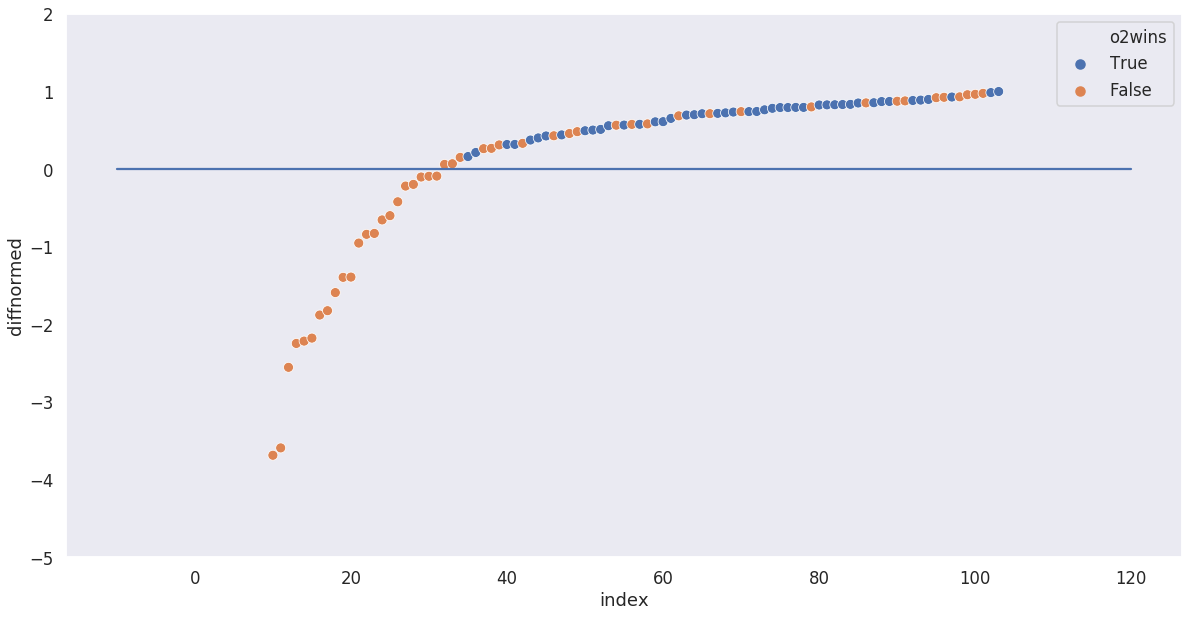

In [318]:
plt.figure(figsize=(20, 10))
plt.plot([-10, 120], [0, 0])
sns.scatterplot(x="index", y="diffnormed", hue="o2wins", hue_order=[True, False], data=sorted_cols_df.reset_index(), s=100)
plt.ylim(-5, 2)
plt.show()

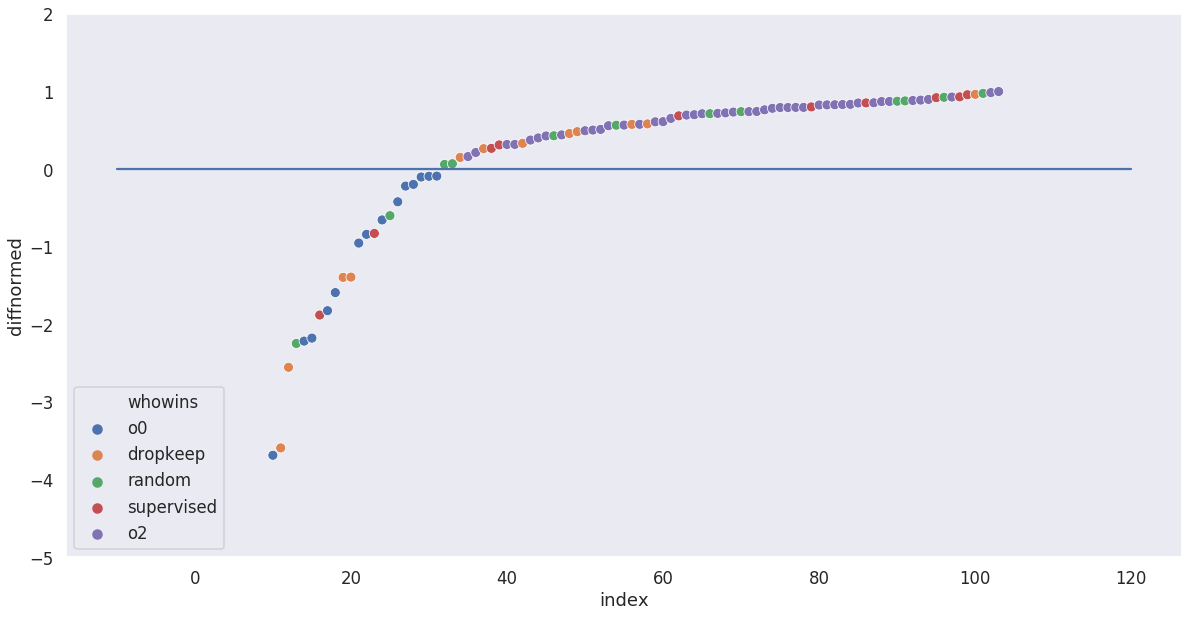

In [320]:
plt.figure(figsize=(20, 10))
plt.plot([-10, 120], [0, 0])
sns.scatterplot(x="index", y="diffnormed", hue="whowins", data=sorted_cols_df.reset_index(), s=100)
plt.ylim(-5, 2)
plt.show()

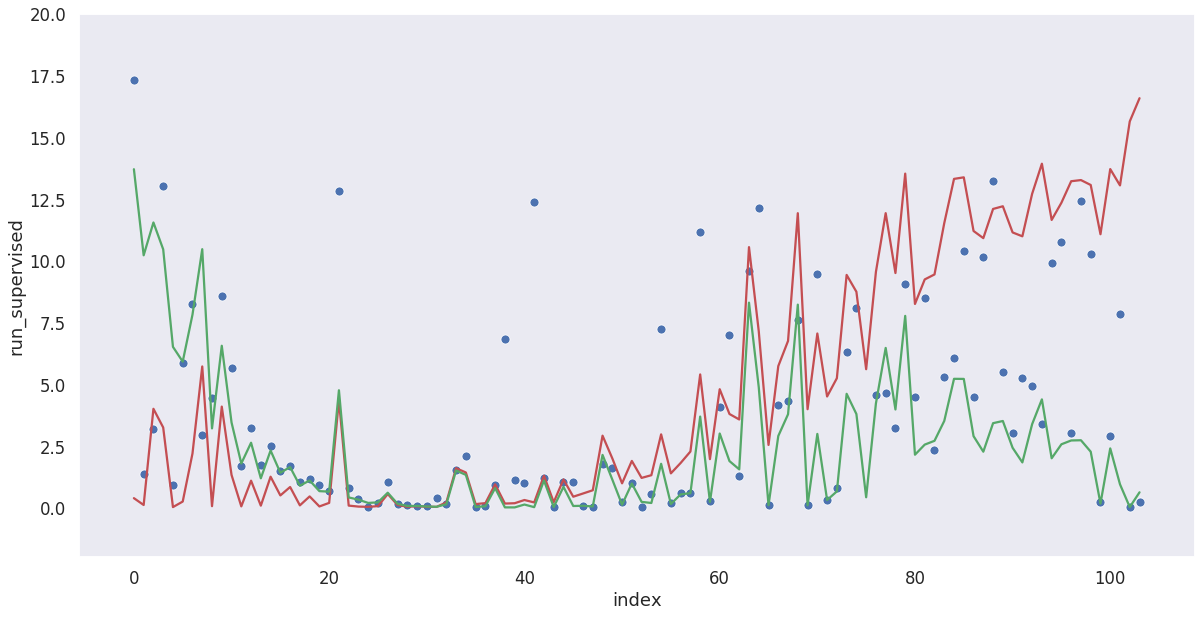

In [405]:
cols_df_sorted_diff = cols_df.sort_values(by="o2_o0_diff").reset_index(drop=True)
plt.figure(figsize=(20, 10))
sns.lineplot(x="index", y="run_o0", data=cols_df_sorted_diff.reset_index(), color="r")
sns.lineplot(x="index", y="run_o2", data=cols_df_sorted_diff.reset_index(), color='g')
#sns.scatterplot(x="index", y="best_my", hue="dropkeep_better", data=sorted_o0.reset_index(), palette="bright")
sns.scatterplot(x="index", y="run_supervised", data=cols_df_sorted_diff.reset_index(), color="b")
plt.ylim(-2, 20)
plt.show()

In [321]:
o2wins = cols_df[cols_df.o2wins]

In [323]:
o2wins.columns

Index(['test_name', 'compile_o2', 'run_o2', 'compile_dropkeep', 'run_dropkeep',
       'compile_o0', 'run_o0', 'compile_supervised', 'run_supervised',
       'compile_random45', 'run_random45', 'o2_o0_diff', 'o2wins',
       'dropkeepwins', 'supervisedwins', 'o0wins', 'randomwins', 'whowins',
       'diffnormed'],
      dtype='object')

In [346]:
o2wins = o2wins.sort_values(by="run_o2").reset_index(drop=True)

In [327]:
o2wins

,test_name,compile_o2,run_o2,compile_dropkeep,run_dropkeep,compile_o0,run_o0,compile_supervised,run_supervised,compile_random45,run_random45,o2_o0_diff,o2wins,dropkeepwins,supervisedwins,o0wins,randomwins,whowins,diffnormed
0,network-dijkstra,0.233850,0.036550,0.835733,0.951233,0.027500,0.153775,5.568600,0.047600,0.263900,1.061400,0.117225,True,False,False,False,False,o2,0.762315
1,rsbench,0.200750,0.020600,2.837000,0.952900,0.018025,0.175000,5.690050,6.837100,0.305617,0.943483,0.154400,True,False,False,False,False,o2,0.882286
2,miniGMG,0.186800,0.019600,1.470700,0.065000,0.028900,0.188533,0.844267,1.119700,0.269900,0.066667,0.168933,True,False,False,False,False,o2,0.896040
3,Symbolics-flt,0.332700,0.066700,0.992300,0.206325,0.030750,0.191600,5.752250,0.077000,0.256200,1.210200,0.124900,True,False,False,False,False,o2,0.651879
4,srad,0.235575,0.029075,1.418400,0.928700,0.019500,0.221200,11.931000,12.382050,0.266975,1.447325,0.192125,True,False,False,False,False,o2,0.868558
5,pathfinder,0.633520,0.076680,0.379600,0.201400,0.043900,0.452300,5.734600,1.038450,0.254300,0.199050,0.375620,True,False,False,False,False,o2,0.830467
6,anagram,0.579700,0.085300,6.743375,0.629400,0.098400,0.582200,6.198400,0.093700,0.302000,0.193800,0.496900,True,False,False,False,False,o2,0.853487
7,mason,0.716200,0.798900,6.691367,4.081233,0.029333,0.951800,6.211340,0.906740,0.483167,4.613900,0.152900,True,False,False,False,False,o2,0.160643
8,netbench-crc,0.271900,0.129260,8.435400,42.128050,0.016150,0.993583,4.805025,0.228850,1.598750,45.238250,0.864323,True,False,False,False,False,o2,0.869905
9,gs,0.273760,0.198300,1.124933,5.992633,0.017850,1.322750,4.722350,0.548350,0.248900,6.018500,1.124450,True,False,False,False,False,o2,0.850085


In [398]:
sorted_o0 = o2wins.sort_values(by="o2_o0_diff").reset_index(drop=True)

In [399]:
dropkeep_better = sorted_o0["run_dropkeep"] < sorted_o0["run_supervised"]

In [400]:
sorted_o0["dropkeep_better"] = dropkeep_better

In [401]:
sorted_o0["best_my"] = sorted_o0["run_supervised"]
sorted_o0.loc[dropkeep_better, "best_my"] = sorted_o0.loc[dropkeep_better, "run_dropkeep"]

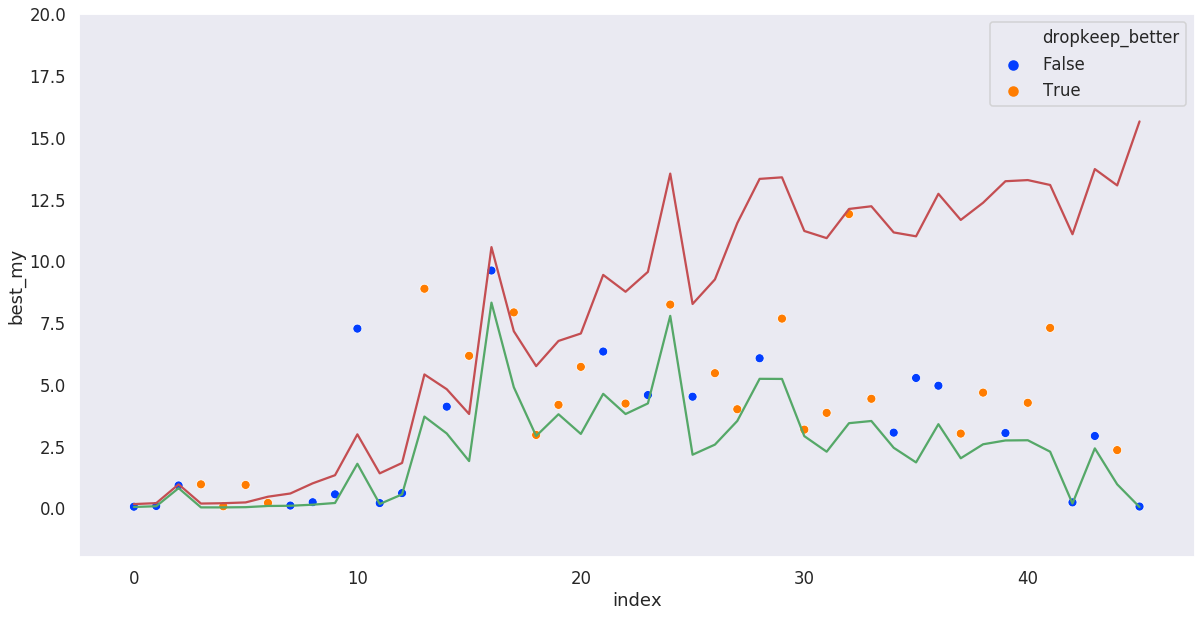

In [402]:
plt.figure(figsize=(20, 10))
sns.lineplot(x="index", y="run_o0", data=sorted_o0.reset_index(), color="r")
sns.lineplot(x="index", y="run_o2", data=sorted_o0.reset_index(), color='g')
sns.scatterplot(x="index", y="best_my", hue="dropkeep_better", data=sorted_o0.reset_index(), palette="bright")
#sns.scatterplot(x="index", y="run_supervised", data=sorted_o0.reset_index(), color="r")
plt.ylim(-2, 20)
plt.show()

In [360]:
sum(sorted_o0.run_o2)

261.5841922619047

In [362]:
sum(sorted_o0.loc[dropkeep_better, "run_dropkeep"]) + sum(sorted_o0.loc[~dropkeep_better, "run_supervised"])

254.5304033333333

In [392]:
dropkeep_wins = cols_df[cols_df.dropkeepwins]
dropkeep_wins = dropkeep_wins.sort_values(by="o2_o0_diff").reset_index(drop=True)

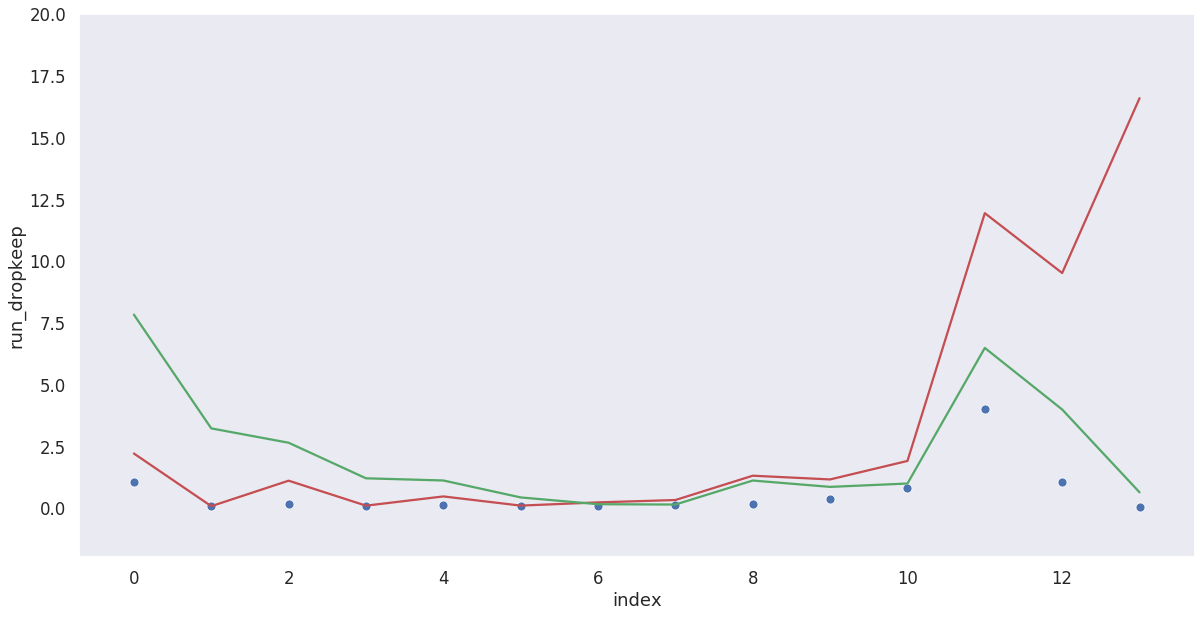

In [393]:
plt.figure(figsize=(20, 10))
sns.lineplot(x="index", y="run_o0", data=dropkeep_wins.reset_index(), color="r")
sns.lineplot(x="index", y="run_o2", data=dropkeep_wins.reset_index(), color='g')
#sns.scatterplot(x="index", y="best_my", hue="dropkeep_better", data=dropkeep_wins.reset_index(), palette="bright")
sns.scatterplot(x="index", y="run_dropkeep", data=dropkeep_wins.reset_index(), color="b")
plt.ylim(-2, 20)
plt.show()

In [394]:
supervised_wins = cols_df[cols_df.supervisedwins]
supervised_wins = supervised_wins.sort_values(by="o2_o0_diff").reset_index(drop=True)

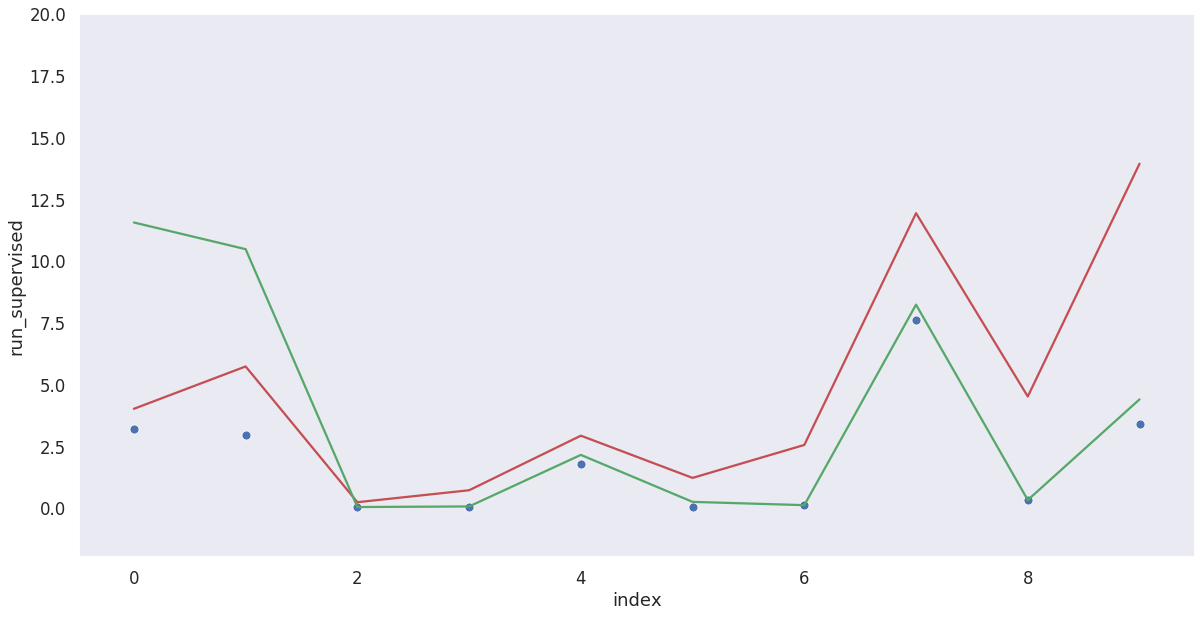

In [396]:
plt.figure(figsize=(20, 10))
sns.lineplot(x="index", y="run_o0", data=supervised_wins.reset_index(), color="r")
sns.lineplot(x="index", y="run_o2", data=supervised_wins.reset_index(), color='g')
#sns.scatterplot(x="index", y="best_my", hue="dropkeep_better", data=dropkeep_wins.reset_index(), palette="bright")
sns.scatterplot(x="index", y="run_supervised", data=supervised_wins.reset_index(), color="b")
plt.ylim(-2, 20)
plt.show()